# Individual Analysis for the H-D Spectrum Experiment

## Centroid method

This template uses a "centroid" calculation to obtain the peak locations.

Use this template to carry out the analysis tasks for the Electron Diffraction experiment.  You may need to consult the documentation for different Python packages.  Also recommended: the [Whirlwind Tour of Python](https://jakevdp.github.io/WhirlwindTourOfPython/) and the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) both by Jake VanderPlas.

## First, import some packages

This is a good idea at the beginning of your notebook to include the packages that you will need.  We will use the four shown below here.  A brief description:
* `numpy` is the foundational package for Python numerical work. It extends and speeds up array operations beyond standard Python, and it includes almost all math functions that you would need for example `sqrt()` (square root) or `cos()` (cosine).  These would be written in code as `np.sqrt()` or `np.cos()`.
* `scipy` is a huge collection of scientific data analysis functions, routines, physicical constants, etc.  This is the second most used package for scientific work. Documentation is at [SciPy.org](https://docs.scipy.org/doc/scipy/reference/) with the constants subpackage at https://docs.scipy.org/doc/scipy/reference/constants.html.
* `uncertainties` is a very useful small package that simplifies uncertainty propagation and printing out of quantities with uncertainty.  Documentation is at https://pythonhosted.org/uncertainties/
* `matplotlib` is *the* standard plotting package for scientific Python.  We will use a subset called `pyplot` which is modeled after the plotting functions used in MATLAB. The last line below, `%matplotlib inline`, simply forces the plots to appear within the notebook.
* `pandas` is a large data science package.  It's main feature is a set of methods to create and manipulate "Dataframes", which is an enlargement of the idea of an array.  It plays well with NumPy and other packages.  We will use it mainly as a way to read files into data sets in an easy way.

We will also be using the [**LMFit**](https://lmfit.github.io/lmfit-py/) curve fitting package.  This library is very powerful and relatively easy to use to perform complex fitting of functions to data sets, and to also extract meaningful values for statistical uncertainties in the fitting parameters.  It will be introduced and imported later in the template.  Documentation is at https://lmfit.github.io/lmfit-py/

In [1]:
# Run this cell with Shift-Enter, and wait until the asterisk changes to a number, i.e., [*] becomes [1]
import numpy as np
import scipy.constants as const
import uncertainties as unc
import uncertainties.unumpy as up
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Part 1 - Calibration

### Read in the data

It is always a good idea to make a plot of the raw data before trying to manipulate it. Before doing this, you should open a data file with a simple text editor to see what it looks like.  You will see some information at the beginning about the oscilloscope's parameters.

Then use the **Pandas** function `read_csv()` to pull the file into a Pandas Dataframe, like this:

```
Na = pd.read_csv('Na_D_lines.csv', skiprows=15)
```

The variable `skiprows` makes the function skip over the header information in the data file produced by the oscilloscope.

If the last line in the cell is the name of the dataframe, it will print a nice table.

You may obtain the arrays for each column by using the column label, e.g., `Na['CH1']` is the array of the first column.

In [2]:
# These lines allow the user to enter a data file
# df = pd.read_csv(filename,skiprows=15)  # skiprows skips header information.

Na = pd.read_csv('Na_D_lines_run1.CSV',skiprows=15)      


In [3]:
# Just using the label alone causes the dataframe to be displayed.

# The "[:10]" truncates the view to the first 10 rows.

Na['CH1']

0      -0.020
1      -0.012
2      -0.020
3      -0.020
4      -0.020
        ...  
5195   -0.012
5196   -0.012
5197   -0.020
5198   -0.012
5199   -0.012
Name: CH1, Length: 5200, dtype: float64

### Plot the data

Below, I show how. Study the commands, change them, and see what happens.  Hint: study the sections in the [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/) on Matplotlib.

Note also the minus sign in front of `Na['CH1']` in the `plt.plot()` function below.  What happens if you remove it?


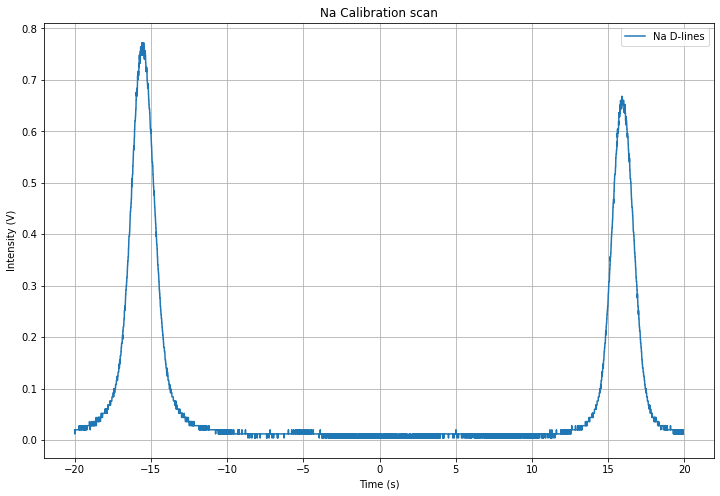

In [4]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Time (s)')
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.legend();

### Locate the peak maxima

There are two parts to this.  Part 1 is to smooth the data, part 2 is to locate the maxima of the smoothed data and the width of the peaks located under the maxima.

To do this we will need two functions from SciPy.

In [5]:
## Import functions from SciPy's collection.  You only need to do an import once in a given session
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

**Part 1.** First, you want to smooth the y-axis (voltage) data a little bit.  Look closely at the plot, and you will notics a kind of "stairstep" quality, especially near the baseline.  This is the limit of the digitization resolution. Smoothing the data a small amount will remove much of this and make it easier to see the shape of the curve.

One way is to use "Gaussian filtering" to do this.  Gaussian filtering uses a gaussian to convolve with the data set.  The numerical parameter parameter gives the width of the gaussian; larger widths mean more smoothing.

In [6]:
# Smoothing with a parameter of 5
# This way of doing it adds another column to the dataframe.
Na['CH1_smoothed'] = gaussian_filter1d(Na['CH1'], 5)

Try plotting the smoothed data over the original data.  Then change the `5` in the `gaussian_filter1d()` function to `100` and see what happens.  **Message:** Be careful with smoothing data sets!

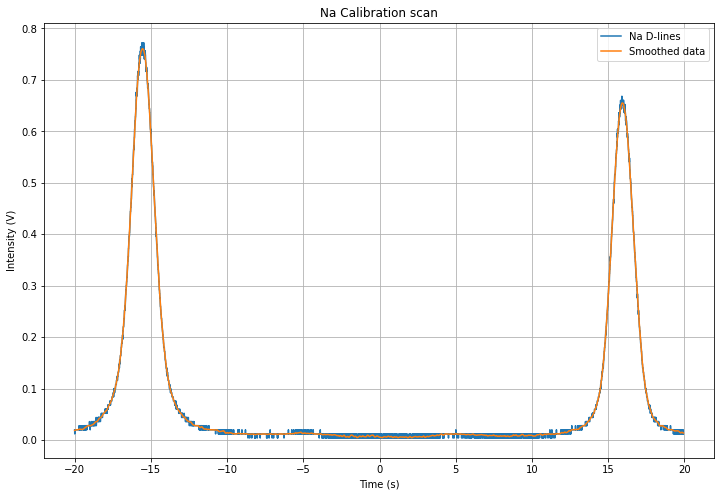

In [7]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Time (s)')
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.plot(Na['TIME'],-Na['CH1_smoothed'],'-',label='Smoothed data')
plt.legend();

**Part 2.** Second, you can use a peak-finding function from SciPy.  This will locate the array indices of peaks in the data sets that satisfy certain criteria.  Using this function takes some care.  You should plot the peak locations and other parameters you are trying to find to make sure it is doing what you want.

I show an example below.

In [8]:

# assign current arrays to xdata, ydata
ydata = -Na['CH1_smoothed']
xdata = Na['TIME']

# A "min width" keeps small fluctuations near the top from being labeled separate peaks
# Width units are array indices
min_width = 50

# Below does the work.  The height parameter makes the function only look 
# for peaks higher than halfway up the tallest peak.
peaks, pk_props = find_peaks(ydata, width = min_width, height = ydata.max()/2.)

for pk, prop in zip(peaks, pk_props['widths']): 
    print('Peak at {:d} has width {:.1f}'.format(pk, prop))


Peak at 579 has width 234.6
Peak at 4678 has width 220.6


Show this with a plot.  Note the use of vlines() and hlines()

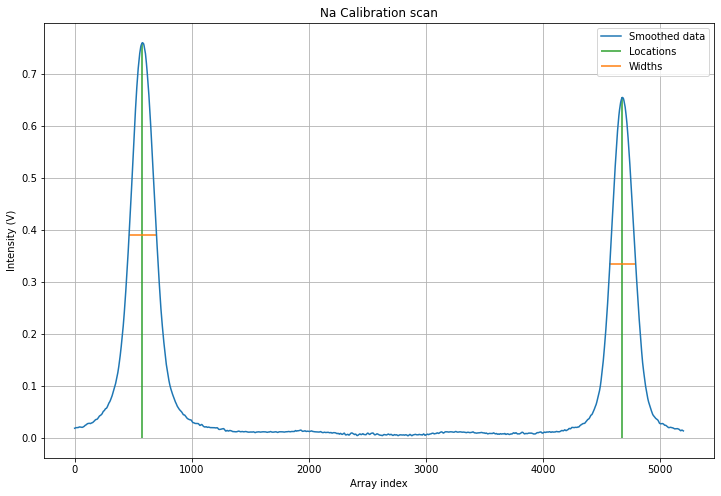

In [9]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Array index')
plt.plot(ydata,'-',label='Smoothed data')
plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2, 
           xmax=peaks+pk_props['widths']/2, color = 'C1', label='Widths')
plt.legend();

You can now save the peak positions and widths.  These will be used to determine either starting values for a peak-fitting routine or to determine the centroid of each peak.  I will show how to do either of these calculations, starting with the centroid finder.

In [10]:
Na_peaks = peaks
Na_widths = pk_props['widths']

In [11]:
# Cull a slice for each peak

# 'extent' is a multiplier of width to get the full peak
extent = 2.5

# pk_indices is a list of the lists of integers corresponing to the indices within a peak

pk_indices = []
for pk, width in zip(Na_peaks, Na_widths): 
    # The folowing statement is a Python "list comprehension".  It is like a loop in compact form
    # data.size is the length of the data array.  This collects all of the indicies that lie in a certain range
    indices = [i for i in range(ydata.size) if (i > pk-extent*width) and (i < pk+extent*width)]
    # Add the list of indices to the bigger list. 
    pk_indices.append(indices)

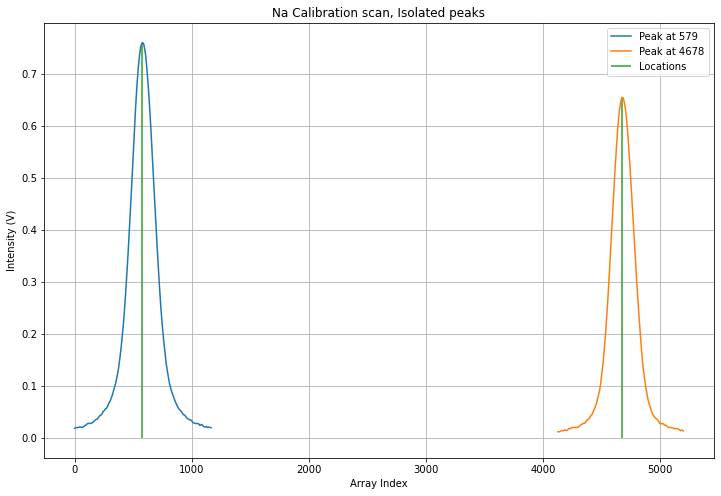

In [12]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('Na Calibration scan, Isolated peaks')
plt.ylabel(r'Intensity (V)')
plt.xlabel(r'Array Index')
for pk, indices in zip(peaks, pk_indices):
        plt.plot(ydata[indices],'-', label='Peak at {:d}'.format(pk))
plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
plt.legend();

Analysis next.

The goal is to calculate a centroid. The centroid is the weighted average of the x position:

$$ x_\text{cent} = \frac{\sum x_iy_i}{\sum y_i}$$

In [13]:
# Function calculates centroid and stddev

def get_centroid(xdata,ydata):
    # calculate weighted average of x-position
    mid = np.sum(xdata*ydata)/np.sum(ydata) 
    return mid

Now use `get_centroid()` and the location of the peak maximum to get the peak location and an uncertainty, defined as the difference between the centrod and the peak maximum.

Save the result into an uncertainty object `ufloat`.

Calculations with uncertainty objects will automatically propagate the uncertainty.

In [14]:
Peak_loc = []

for pk, indices in zip(Na_peaks, pk_indices) :
    mid_time = get_centroid(xdata[indices],ydata[indices])
    max_time = xdata[pk]
    peak_time = unc.ufloat(mid_time, np.abs(max_time - mid_time))
    Peak_loc.append(peak_time)
    print('Peak at index {:d} = {:.2uP} s'.format(pk,peak_time))

Na_loc = Peak_loc

Peak at index 579 = -15.533±0.020 s
Peak at index 4678 = 15.944±0.015 s


Next, calculate the calibration constant with its uncertainty.  This is easy if you are using the uncertainty object.

The calibration constant $K_\text{Na}$ is simply

$$ K_\text{Na} = \frac{\lambda_{\text{D}_1}-\lambda_{\text{D}_2}}{t_{\text{D}_1}-t_{\text{D}_2}}$$

By definition, $D_1$ has a longer wavelength than $D_2$.

In [15]:
## You write this.  Create a calibration constant with uncertainty

D_1 = 5895.92
D_2 = 5889.95

K_Na = (D_1-D_2)/(Na_loc[-1]-Na_loc[-2])

print('Calibration constant from centroid method: {:.2uP} A/s'.format(K_Na))

Calibration constant from centroid method: 0.18967±0.00015 A/s


## Part 2 - Data reduction

### Read in and plot all of the data

Before doing any calculations, you shoul always plot and look hard at your data.

Repeat the steps at the beginning to feed each data set into a Pandas dataframe.

In [16]:

## Collect all the data sets into active dataframes. 
## Follow the method used for the Na lines
Alpha = pd.read_csv('HD_Alpha_run1.CSV',skiprows=15)
Beta = pd.read_csv('HD_Beta_run1.CSV',skiprows=15)
Delta = pd.read_csv('HD_Delta_run1.CSV',skiprows=15)
Gamma = pd.read_csv('HD_Gamma_run1.CSV',skiprows=15)
Epsilon1 = pd.read_csv('HD-Epsilon_run1.CSV',skiprows=15)
Epsilon2 = pd.read_csv('HD-Epsilon_run2.CSV',skiprows=15)


## Recommended names  for te dataframes 'Alpha', 'Beta', 'Gamma', etc.


Now plot all on one graph.  Don't forget "-" to flip all data sets to positive

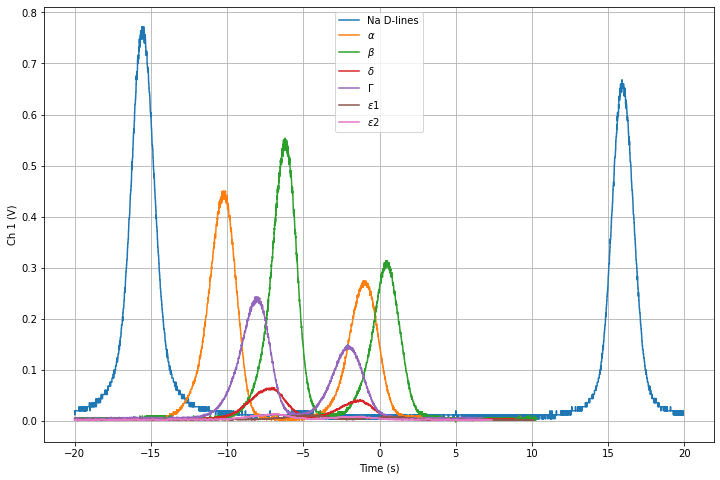

In [17]:
plt.figure(figsize=(12,8))
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.plot(Alpha['TIME'],-Alpha['CH1'],'-',label=r'$\alpha$')
plt.plot(Beta['TIME'],-Beta['CH1'],'-',label=r'$\beta$')
plt.plot(Delta['TIME'],-Delta['CH1'],'-',label=r'$\delta$')
plt.plot(Gamma['TIME'],-Gamma['CH1'],'-',label=r'$\Gamma$')
plt.plot(Epsilon1['TIME'],-Epsilon1['CH1'],'-',label=r'$\epsilon$1')
plt.plot(Epsilon2['TIME'],-Epsilon2['CH1'],'-',label=r'$\epsilon$2')

plt.xlabel(r'Time (s)')
plt.ylabel(r'Ch 1 (V)')
plt.legend()
plt.grid();

Hard to read.  Offset the plots by adding constants to each array, and rescale them by multiplying a constant with each array. 

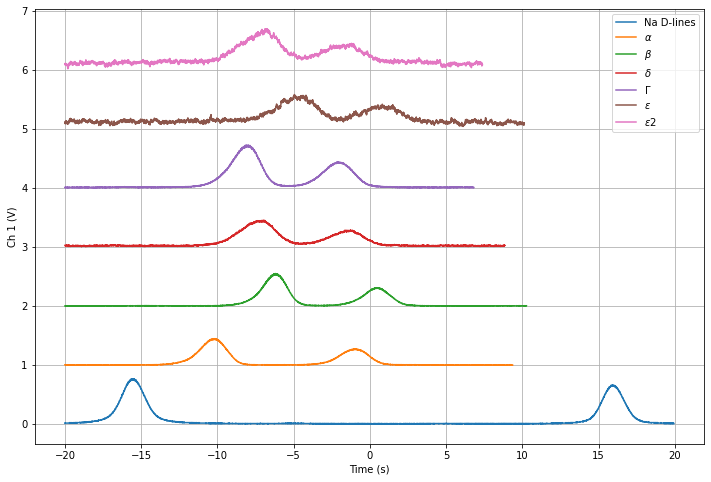

In [18]:
## Cut and paste above, and then manipulate arrays within the plot() calls

plt.figure(figsize=(12,8))
plt.plot(Na['TIME'],-Na['CH1'],'-',label='Na D-lines')
plt.plot(Alpha['TIME'],-Alpha['CH1']+1,'-',label=r'$\alpha$')
plt.plot(Beta['TIME'],-Beta['CH1']+2,'-',label=r'$\beta$')
plt.plot(Delta['TIME'],-7*Delta['CH1']+3,'-',label=r'$\delta$')
plt.plot(Gamma['TIME'],-3*Gamma['CH1']+4,'-',label=r'$\Gamma$')
plt.plot(Epsilon1['TIME'],-50*Epsilon1['CH1']+5,'-',label=r'$\epsilon$')
plt.plot(Epsilon2['TIME'],-50*Epsilon2['CH1']+6,'-',label=r'$\epsilon$2')

plt.xlabel(r'Time (s)')
plt.ylabel(r'Ch 1 (V)')
plt.legend()
plt.grid();

### Process each data file

At this point, you want to apply the same basic steps to each H-D spectrum files, namely:

* Smooth it.
* Locate the peak positions and widths.
* Use this information to calculate the centroids.
* Determine a position and uncertainty for each peak in the data file.
* Calculate $\Delta t_\text{HD}$ for the file, and save it.

Before doing these steps, convert the code blocks used to carry out these tasks to functions.  This will make your code reuse less messy and easier to run.

In [19]:
## Function to locate the peaks, plot them, and return the important data

def find_and_plot_peaks(ydata, title='Data', makeplot=True):
    '''
    Function locates peaks using SciPy.signal find_peaks() and plots
    the results (optionally).  Returns two arrays: 'peaks' which holds
    the index of each peak maximum and 'widths' which holds the FWHM of
    each peak.
    '''
    #NOTE: the data feed in must be smoothed data
    #Find max
    min_width = 50
    peaks, pk_props = find_peaks(ydata, width = min_width, height = ydata.max()/2.)
    
    #Optional plotting
    if makeplot==True:
        plt.figure(figsize=(12,8))
        plt.grid()
        plt.title(title+' '+'Calibration scan')
        plt.ylabel(r'Intensity (V)')
        plt.xlabel(r'Array index')
        plt.plot(ydata,'-',label='Smoothed data')
        plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
        plt.hlines(y=pk_props['width_heights'], xmin=peaks-pk_props['widths']/2,
                   xmax=peaks+pk_props['widths']/2, color = 'C1', label='Widths')
        plt.legend();
    
    return peaks, pk_props['widths']

In [20]:
## Function to obtain lists of indices spanning each peak

def select_peak_indices(ydata, peaks, widths, title='Data', extent=2.5, makeplot=True):
    '''
    Function uses peak finding result to build a list of indices that 
    span each peak according to the 'extent' parameter.  Optionally plots
    the result.  Returns a list of lists.
    '''
    #Creat a list of indices
    pk_indices = []
    for pk, width in zip(peaks, widths): 
        indices = [i for i in range(ydata.size) if (i > pk-extent*width) and (i < pk+extent*width)]
        pk_indices.append(indices)
        
    #Optional plotting
    if makeplot==True:
        plt.figure(figsize=(12,8))
        plt.grid()
        plt.title(title + ' ' + 'Calibration scan, Isolated peaks')
        plt.ylabel(r'Intensity (V)')
        plt.xlabel(r'Array Index')
        
        #print(pk_indices[1], peaks[1])
        plt.plot(ydata[pk_indices[1]],'-', label='Peak at {:d}'.format(peaks[1]))
        
        for pk, indices in zip(peaks, pk_indices):
            plt.plot(ydata[indices],'-', label='Peak at {:d}'.format(pk))
        plt.vlines(x=peaks, ymin=0, ymax=ydata[peaks], color='C2', label='Locations')
        plt.legend();
    
    return pk_indices

In [21]:
def calculate_peak_locs(xdata, ydata, peaks, peak_indices):
    '''
    Function uses peaks array and lists of indices to calculate
    centroids of each peak in units of the 'xdata' array.  
    Returns a list of uncertainty objects whil each value being the centroid 
    and each uncertainty being the difference between the peak maximum location
    and the centroid.
    '''
    Peak_loc = []
    
    for pk, indices in zip(peaks, peak_indices) :
        mid_time = get_centroid(xdata[indices],ydata[indices])
        max_time = xdata[pk]
        peak_time = unc.ufloat(mid_time, np.abs(max_time - mid_time))
        Peak_loc.append(peak_time)
    
    return Peak_loc

[-15.532574695616981+/-0.020425304383019594, 15.943774358907264+/-0.014774358907263974]


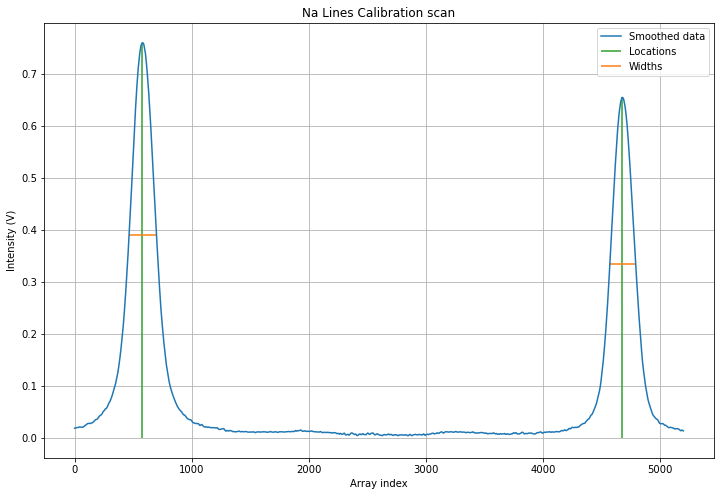

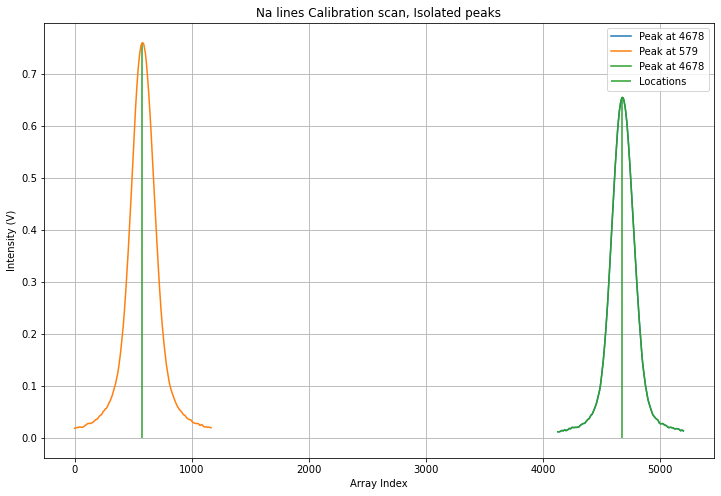

In [22]:
Na_pks, Na_widths = find_and_plot_peaks(ydata, title='Na Lines', makeplot=True)
Na_test_indices = select_peak_indices(ydata, Na_pks, Na_widths, title='Na lines')
Na_test_loc = calculate_peak_locs(xdata, ydata, Na_pks, Na_test_indices)

print(Na_test_loc)


### Apply the functions

Work on Alpha first.  Below I show the first example. Re-use `xdata`, `ydata`, `peaks`, and `widths` to save typing.  **But be careful:** if you execute cells out of sequence, you will get peculiar results!!

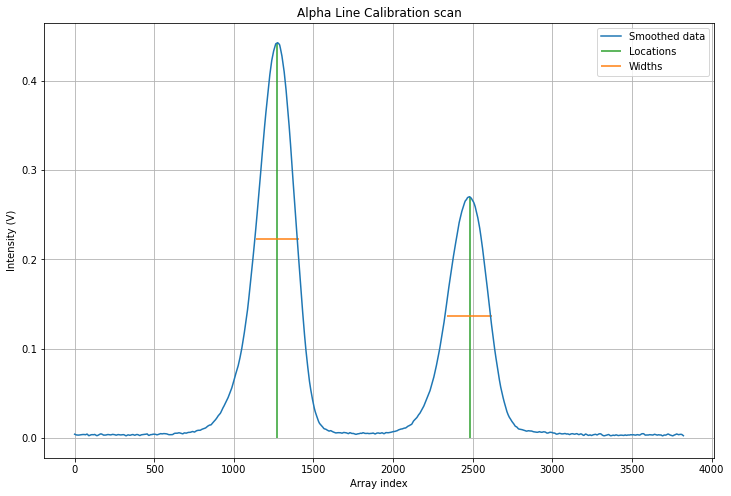

In [23]:
## Prepare the Alpha lines
Alpha['CH1_smoothed'] = gaussian_filter1d(Alpha['CH1'], 5)

xdata = Alpha['TIME']
ydata = -Alpha['CH1_smoothed']

## Execute the first function
peaks, widths = find_and_plot_peaks(ydata, title='Alpha Line', makeplot=True)

Next step: isolate peaks and calculate.

One may need to adjust the `extent` parameter.

Results saved to `Alpha_loc`.  Will repeat for `Beta_loc`, `Gamma_loc`, etc.

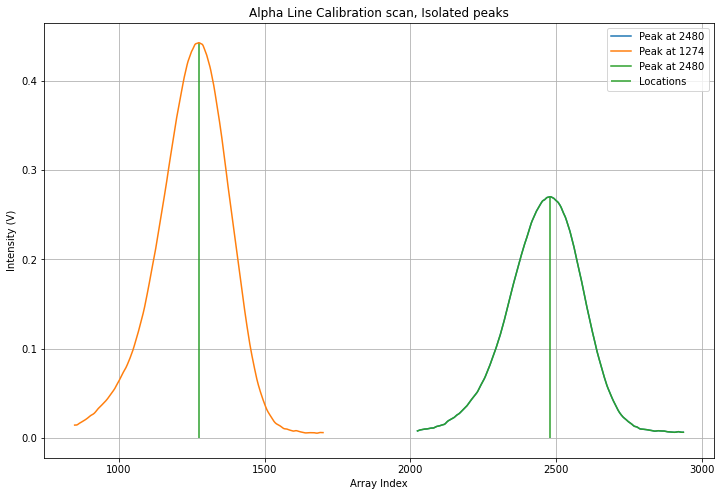

In [24]:
## Execute the second and third functions
indices = select_peak_indices(ydata, peaks, widths, extent=1.6, title='Alpha Line')
Alpha_loc = calculate_peak_locs(xdata, ydata, peaks, indices)

### Repeat for other lines.  

Beta next.

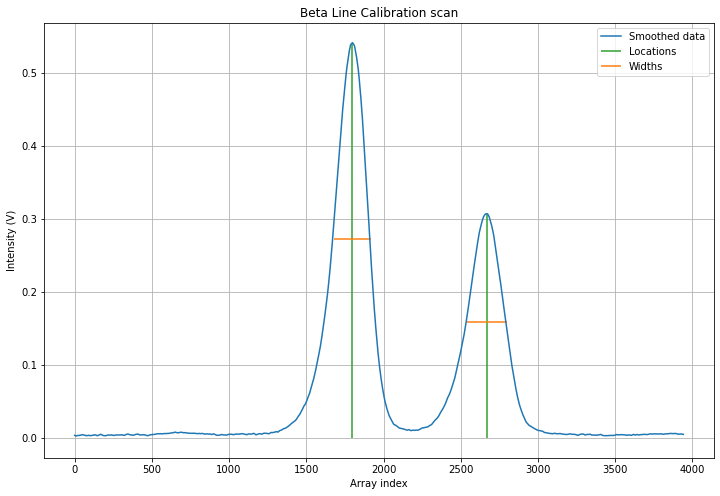

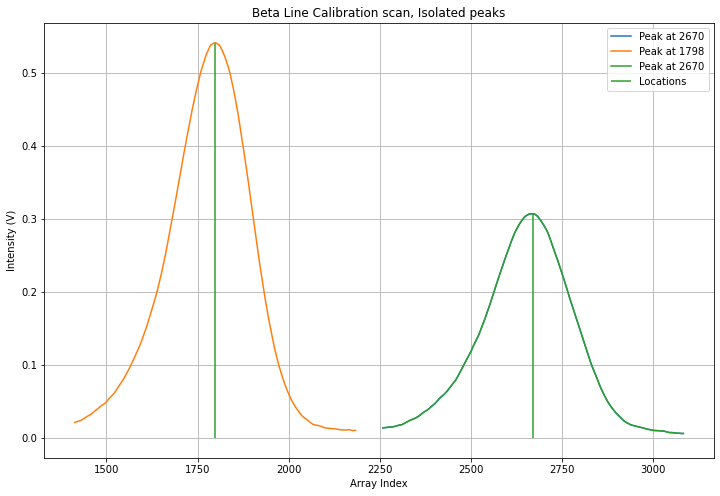

In [25]:
Beta['CH1_smoothed'] = gaussian_filter1d(Beta['CH1'], 5)

xdata = Beta['TIME']
ydata = -Beta['CH1_smoothed']
# First function
peaks, widths = find_and_plot_peaks(ydata, title='Beta Line', makeplot=True)
# second and third calls
indices = select_peak_indices(ydata, peaks, widths, extent=1.6, title='Beta Line')
Beta_loc = calculate_peak_locs(xdata, ydata, peaks, indices)

Gamma next.

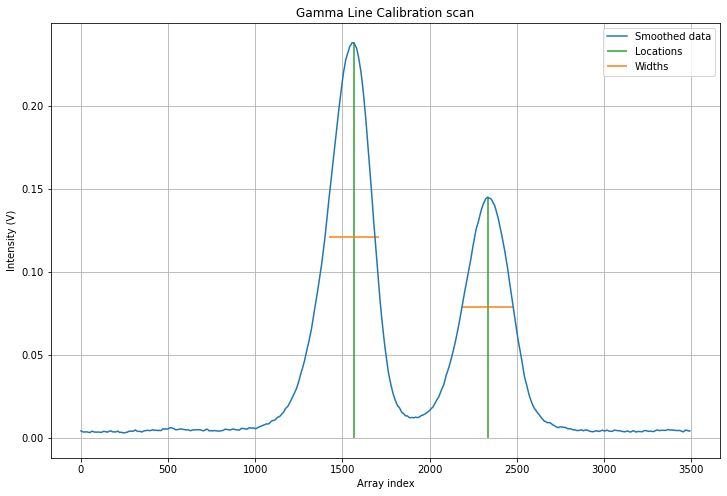

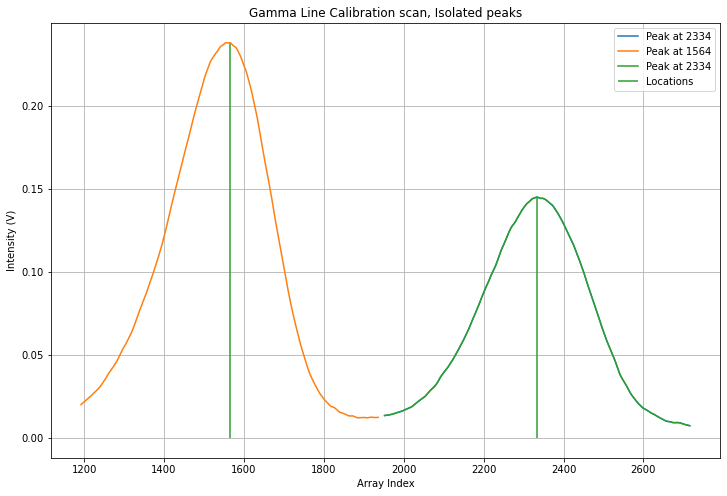

In [26]:
Gamma['CH1_smoothed'] = gaussian_filter1d(Gamma['CH1'], 5)
xdata = Gamma['TIME']
ydata = -Gamma['CH1_smoothed']

## Execute the first function
peaks, widths = find_and_plot_peaks(ydata, title='Gamma Line', makeplot=True)

## Second and third functions
indices = select_peak_indices(ydata, peaks, widths, extent=1.3, title='Gamma Line')
Gamma_loc = calculate_peak_locs(xdata, ydata, peaks, indices)

Delta next.

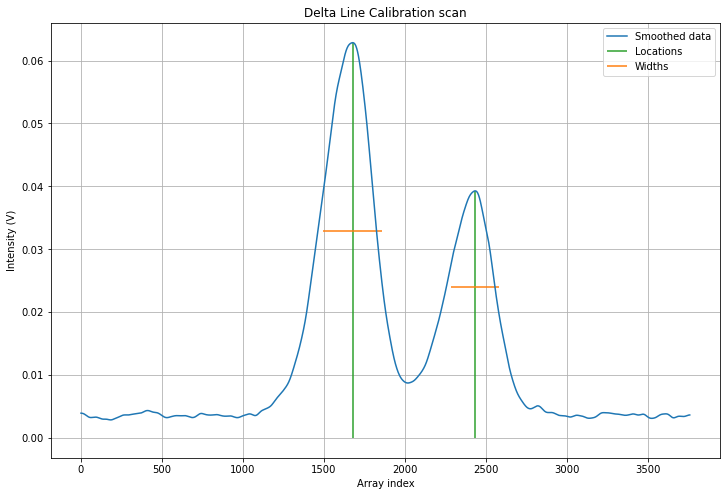

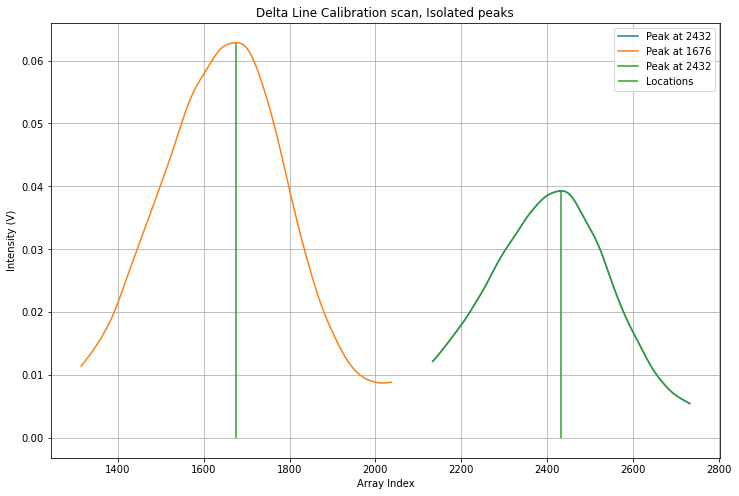

In [27]:
Delta['CH1_smoothed'] = gaussian_filter1d(Delta['CH1'], 18)
xdata = Delta['TIME']
ydata = -Delta['CH1_smoothed']

## Execute the first function
peaks, widths = find_and_plot_peaks(ydata, title='Delta Line', makeplot=True)

## Second and third functions
indices = select_peak_indices(ydata, peaks, widths, extent=1., title='Delta Line')
Delta_loc = calculate_peak_locs(xdata, ydata, peaks, indices)

Finally, Epsilon lines (2 sets).

[-4.747387366048457+/-0.09298736604845725, 0.7232838966416015+/-0.02172610335839842]


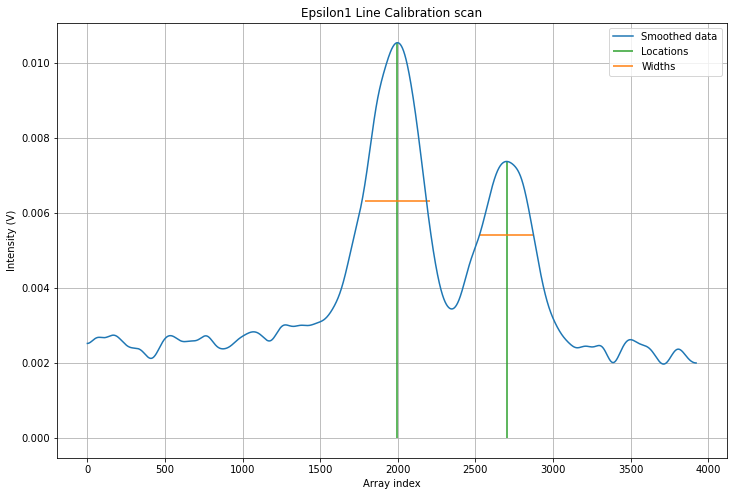

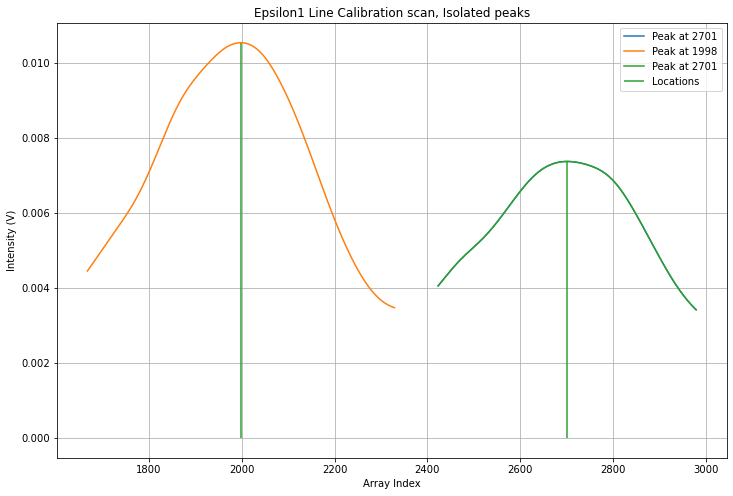

In [28]:
Epsilon1['CH1_smoothed'] = gaussian_filter1d(Epsilon1['CH1'], 40)
xdata = Epsilon1['TIME']
ydata = -Epsilon1['CH1_smoothed']

## Execute the first function
peaks, widths = find_and_plot_peaks(ydata, title='Epsilon1 Line', makeplot=True)

## Second and third functions
indices = select_peak_indices(ydata, peaks, widths, extent=0.8, title='Epsilon1 Line')
Epsilon1_loc = calculate_peak_locs(xdata, ydata, peaks, indices)
print(Epsilon1_loc)

Epsilon 2.

[-7.043275470499718+/-0.13087547049971793, -1.5691390171276307+/-0.11753901712763071]


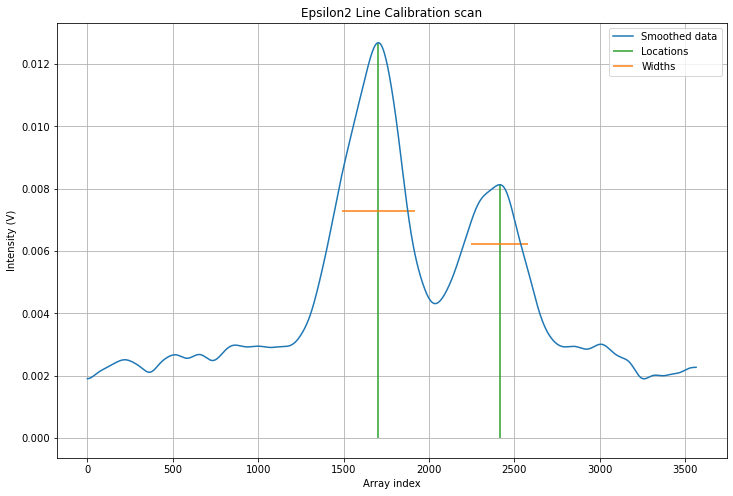

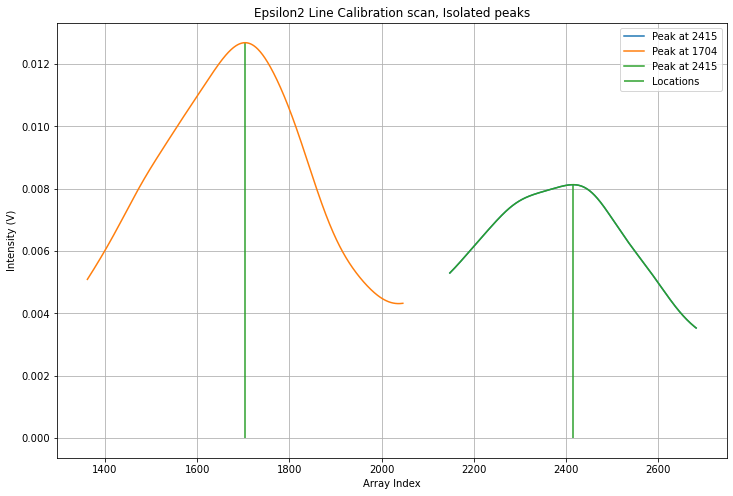

In [29]:
Epsilon2['CH1_smoothed'] = gaussian_filter1d(Epsilon2['CH1'], 40)
xdata = Epsilon2['TIME']
ydata = -Epsilon2['CH1_smoothed']

## Execute the first function
peaks, widths = find_and_plot_peaks(ydata, title='Epsilon2 Line', makeplot=True)

## Second and third functions
indices = select_peak_indices(ydata, peaks, widths, extent=0.8, title='Epsilon2 Line')
Epsilon2_loc = calculate_peak_locs(xdata, ydata, peaks, indices)
print(Epsilon2_loc)

## Save the time differences

One easy way is to make a simple Python list:

In [30]:
D_T = [Alpha_loc[1]-Alpha_loc[0],
      Beta_loc[1]-Beta_loc[0],
      Gamma_loc[1]-Gamma_loc[0],
      Delta_loc[1]-Delta_loc[0],
      Epsilon1_loc[1]-Epsilon1_loc[0],
      Epsilon2_loc[1]-Epsilon2_loc[0]]
D_T

[9.298734750810592+/-0.23503254688672118,
 6.706459535010748+/-0.21026290822650875,
 6.061895281058872+/-0.23388714459995003,
 5.81945111677131+/-0.2640913908672388,
 5.470671262690058+/-0.09549174734902274,
 5.474136453372087+/-0.17590852544959837]

A fancier way is to build a Pandas Series.  I also average the two epsilon runs.

In [31]:
Delta_T = pd.Series({'Alpha': Alpha_loc[1]-Alpha_loc[0],
                   'Beta': Beta_loc[1]-Beta_loc[0],
                   'Gamma': Gamma_loc[1]-Gamma_loc[0],
                   'Delta': Delta_loc[1]-Delta_loc[0],
                   'Epsilon': (Epsilon1_loc[1]+Epsilon2_loc[1]-Epsilon1_loc[0]-Epsilon2_loc[0])/2.0})
Delta_T

Alpha      9.30+/-0.24
Beta       6.71+/-0.21
Gamma      6.06+/-0.23
Delta      5.82+/-0.26
Epsilon    5.47+/-0.10
dtype: object

Then include the known hydrogen wavelengths $\lambda_\text{H}$.  A table can be found in Haken & Wolf, p.98

In [32]:
lambda_H = pd.Series({'Alpha': 6562.79,
                   'Beta': 4863.33,
                   'Gamma': 4340.46,
                   'Delta': 4101.73,
                   'Epsilon': 3970.07})
lambda_H

Alpha      6562.79
Beta       4863.33
Gamma      4340.46
Delta      4101.73
Epsilon    3970.07
dtype: float64

Build into a dataframe.

In [33]:
HD_results = pd.DataFrame({'lambda_H (A)':lambda_H, 'Delta-t (s)': Delta_T})
HD_results

,lambda_H (A),Delta-t (s)
Alpha,6562.79,9.30+/-0.24
Beta,4863.33,6.71+/-0.21
Gamma,4340.46,6.06+/-0.23
Delta,4101.73,5.82+/-0.26
Epsilon,3970.07,5.47+/-0.10


In [34]:
HD_results['Delta-lambda (A)'] = HD_results['Delta-t (s)']*K_Na
HD_results

,lambda_H (A),Delta-t (s),Delta-lambda (A)
Alpha,6562.79,9.30+/-0.24,1.76+/-0.04
Beta,4863.33,6.71+/-0.21,1.27+/-0.04
Gamma,4340.46,6.06+/-0.23,1.15+/-0.04
Delta,4101.73,5.82+/-0.26,1.10+/-0.05
Epsilon,3970.07,5.47+/-0.10,1.038+/-0.019


## Make a plot

Plot the results of $\Delta t_\text{HD}$ versus $\lambda_\text{H}$ with the uncertainty as errorbars.  Include the origin in the plot.

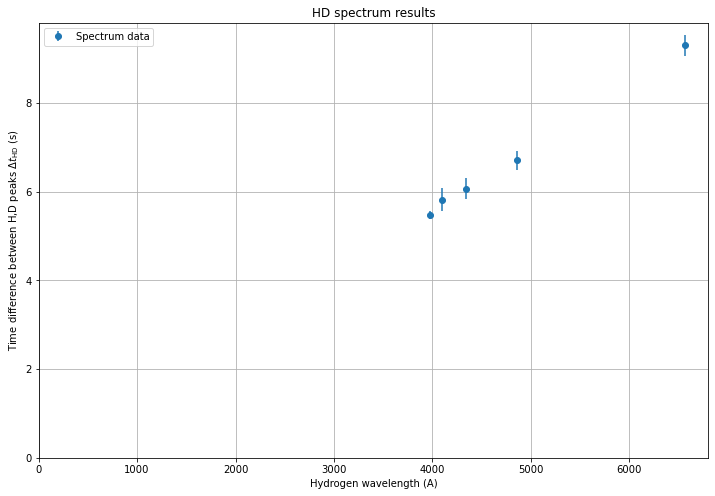

In [35]:
plt.figure(figsize=(12,8))
plt.grid()
plt.title('HD spectrum results')
plt.ylim(0,9.8)
plt.xlim(0,6800.0)
plt.ylabel(r'Time difference between H,D peaks $\Delta t_{\rm HD}$ (s)')
plt.xlabel(r'Hydrogen wavelength (A)')
## up.nominal_values() and up.std_devs() separates out the values and uncertainties from the uncertainty
## objects
plt.errorbar(HD_results['lambda_H (A)'],up.nominal_values(HD_results['Delta-t (s)']),fmt='o',
             yerr=up.std_devs(HD_results['Delta-t (s)']),label='Spectrum data');
plt.legend();



## Fit the results

To fit the results to a line, make use of the **lmfit** package. It is a useful add-on to the SciPy fitting functions.  This package simplifies fitting data to a variety of standard functions.  See the [Lmfit Documentation](https://lmfit.github.io/lmfit-py/index.html) for a full discussion.  The package is quite powerful, but for basic fitting with common functions, it is very easy to use.  

#### Example: Fitting a line

The example below shows how to use the package to fit data to a line, obtain the fit parameters along with uncertainties, and then plot the data and fit. Execute the cells and study how it works.
(Note: the data come from a calibration problem in physics 331)

The first cell is just example data.

In [36]:
# Calibration Data
# First column is wavelength (nm), second is carriage poisition (cm)
#
Cal_data = np.array([
    [643.85, 41.43],
    [579.07, 37.24],
    [576.96, 37.11],
    [546.08, 35.10],
    [508.58, 32.68],
    [479.99, 30.83],
    [467.81, 30.04],
    [435.83, 27.96],
    [404.66, 25.98]])

# Array slicing separates x (position) and y (wavelength)
# Goal of calibration is to be able to feed in a position and obtain a wavelength
wavelength = Cal_data[:,0]
position = Cal_data[:,1]

Here is the fitting example.  Note the very first command

In [37]:
'''
# imports a linear fitting model from lmfit
# You only need to execute this line once!
from lmfit.models import LinearModel

# create an instance of the model
line = LinearModel()

# One must have a guess of the parameters. The guess() method works with most of the standard
# lmfit models
param_guess = line.guess(wavelength, x=position)

# The line below executes the fitting process.  The results are returned to "line_fit"
line_fit = line.fit(wavelength, param_guess, x=position)

# This prints the results in an easy to read form
print(line_fit.fit_report())

# The parameters and uncertainties are accessible as follows, for example:
print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)

#Then you can plot the results quickly just to see how it looks using the plot() method
line_fit.plot();
'''

'\n# imports a linear fitting model from lmfit\n# You only need to execute this line once!\nfrom lmfit.models import LinearModel\n\n# create an instance of the model\nline = LinearModel()\n\n# One must have a guess of the parameters. The guess() method works with most of the standard\n# lmfit models\nparam_guess = line.guess(wavelength, x=position)\n\n# The line below executes the fitting process.  The results are returned to "line_fit"\nline_fit = line.fit(wavelength, param_guess, x=position)\n\n# This prints the results in an easy to read form\nprint(line_fit.fit_report())\n\n# The parameters and uncertainties are accessible as follows, for example:\nprint(\'\nSlope = \',line_fit.params[\'slope\'].value,\'+/-\',line_fit.params[\'slope\'].stderr)\n\n#Then you can plot the results quickly just to see how it looks using the plot() method\nline_fit.plot();\n'

Now apply the above to your data set. The intercept will vary by default.

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 3
    # data points      = 5
    # variables        = 2
    chi-square         = 9.3990e-04
    reduced chi-square = 3.1330e-04
    Akaike info crit   = -38.8958603
    Bayesian info crit = -39.6769845
[[Variables]]
    slope:      2.7450e-04 +/- 8.3498e-06 (3.04%) (init = 0.0002745028)
    intercept: -0.04332739 +/- 0.04058852 (93.68%) (init = -0.04332739)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.981

Slope =  0.00027450278603453004 +/- 8.349799402408224e-06


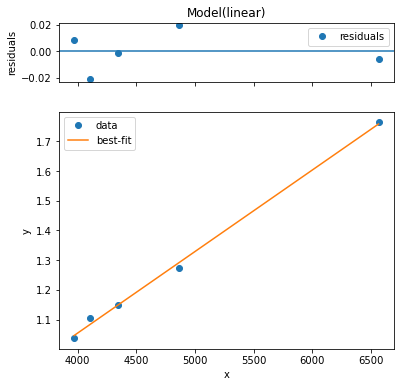

In [38]:
## Put the data into simple arrays: xdata, ydata, yuncert

xdata = HD_results['lambda_H (A)']
ydata = up.nominal_values(HD_results['Delta-lambda (A)'])
yuncert = up.std_devs(HD_results['Delta-lambda (A)'])

## Then use the above code starting with "param_guess = line.guess(wavelength, x=position)"
## and change the variable assignments appropriately to make your fit
from lmfit.models import LinearModel

line = LinearModel()
param_guess = line.guess(ydata, x=xdata)
line_fit = line.fit(ydata, param_guess, x=xdata)
print(line_fit.fit_report())
print('\nSlope = ',line_fit.params['slope'].value,'+/-',line_fit.params['slope'].stderr)
line_fit.plot();



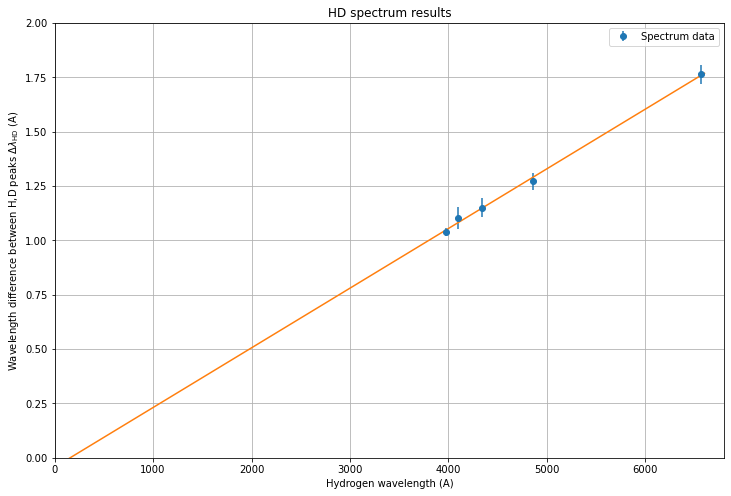

In [39]:
## Code below makes a fitline

xfit = np.linspace(0,6600,10)
yfit = line_fit.eval(line_fit.params, x=xfit)

## Cut and paste the earlier plot, and include the fitline.
plt.figure(figsize=(12,8))
plt.grid()
plt.title('HD spectrum results')
plt.ylim(0,2)
plt.xlim(0,6800.0)
plt.ylabel(r'Wavelength difference between H,D peaks $\Delta \lambda_{\rm HD}$ (A)')
plt.xlabel(r'Hydrogen wavelength (A)')
## up.nominal_values() and up.std_devs() separates out the values and uncertainties from the uncertainty
## objects
plt.errorbar(HD_results['lambda_H (A)'],up.nominal_values(HD_results['Delta-lambda (A)']),fmt='o',
             yerr=up.std_devs(HD_results['Delta-lambda (A)']),label='Spectrum data');
plt.plot(xfit, yfit)
plt.legend();

In [40]:
## Save the slope from the fit.
HD_slope = unc.ufloat(line_fit.params['slope'].value,line_fit.params['slope'].stderr)

## Then use it in a calculation to obtain the mass ratio and uncertainty, and print it out
print(HD_slope)
## You write code to calculate the mass ratio.
mass_ratio = 1-(1837.15*HD_slope)

print('Calculated Mass ratio of hydrogen/deuterium = {:.1uP}'.format(mass_ratio))

0.000275+/-0.000008
Calculated Mass ratio of hydrogen/deuterium = 0.50±0.02
